<a href="https://colab.research.google.com/github/yashveersinghsohi/OCR_HandWritten_Form/blob/master/OCR_Handwritten_Form.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Packages

In [1]:
# Data Manipulation
import numpy as np
from collections import namedtuple

# Loading Pre-trained Model
from keras.models import model_from_json

# Displaying Images
import matplotlib.pyplot as plt

# Image Processing
import cv2
import imutils

# Helper Functions

## Aligning Images

This function is used to take an image and a template as input and return the **aligned** version of the image w.r.t the template. This is acomplished using feature extraction algorithm in OpenCV - **ORB**. The features extracted for both the image and the template are matched and the top most matches are used to align the image using **Warp Perspective** function of OpenCV. 

**Parameters:**
- ***imgGray:*** Gray Scale Image. This image will be aligned.
- ***templateGray:*** Gray Scale Template Image. This image will be used as reference for alignment.
- ***maxFeatures (deafult = 1500):*** Number of keypoints to compute for *imgGray* and *templateGray*.
- ***keepPercent (default = 0.2) :*** Controls the number of keypoints that will be used to align the *imgGray* to *templateGray*.

**Returns**: This function returns 4 images
- ***imgGray:*** Gray Scale Image.
- ***templateGray:*** Gray Scale Template Image.
- ***matchedVis:***: An image that shows the keypoints of both the *imgGray* and *templateGray* being mapped
- ***aligned:*** The final aligned *imgGray* image.

In [2]:
def align_imgs(imgGray, templateGray, maxFeatures = 1500, keepPercent = 0.2):
  # Key Point and Descriptors for "imgGray" and "templateGray"
  orb = cv2.ORB_create(maxFeatures)
  (kpsA, descsA) = orb.detectAndCompute(imgGray, None)
  (kpsB, descsB) = orb.detectAndCompute(templateGray, None)

  # Key point matching based on descriptors
  matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
  matches = matcher.match(descsA, descsB)
  matches = sorted(matches, key=lambda x:x.distance)

  # Filtering strongly matched Keypoints
  keep = int(len(matches) * keepPercent)
  matches = matches[:keep]

  # Drawing Matching Points
  matchedVis = cv2.drawMatches(imgGray, kpsA, templateGray, kpsB, matches, None)
  matchedVis = imutils.resize(matchedVis, width=1000)

  # Points for Warping
  ptsA = np.zeros((len(matches), 2), dtype="float")
  ptsB = np.zeros((len(matches), 2), dtype="float")

  for (i, m) in enumerate(matches):
    ptsA[i] = kpsA[m.queryIdx].pt
    ptsB[i] = kpsB[m.trainIdx].pt

  # Warp Matrix
  (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)

  # Warping
  (h, w) = templateGray.shape[:2]
  aligned = cv2.warpPerspective(imgGray, H, (w, h))

  return [imgGray, templateGray, matchedVis, aligned]

## Predicting Text for a ROI

- This function takes in an image, and the properties of a Region of Interest (roi) in the image, such as the cordinates, the thickness of the smaller box in the roi, and the number of smaller boxes in the roi. 
- Then the function uses appropriate thresholding and padding to convert the smaller boxes of the roi to (1, 32, 32, 1) shape. 
- This is important because the RESNET model needs this image as the input. 
- The text extracted from each smaller box in the roi is concatenated to get the final result.


**Parameters:**
- ***img:*** Input Image.
- ***cordinates:*** The Top-Left (x, y) and the Bottom-right (X, Y) cordinates for the roi denoted by: (x, y, X, Y)
- ***nob:*** Number of smaller boxes present in the roi. The text is contained in these smaller boxes. The function loops over all these boxes to extract text from each one of them.
- ***bt:*** (Inner) Box Thickness.
- ***model:*** The pre-trained model to be used to classify the handwritten text in each of the smaller boxes. Here RESNET is the model that was used.
- ***trim (default = 0.2):*** The percent of pixels to trim off the edges. This controls whether we are using the center pixels only
- ***th (default = 0.2):*** This controls the threshold that controls whether a text extracted from the image is significant or not. 


**Returns:** This function returns a string of text that is extracted from the roi.

In [3]:
def pred_txt_roi(img, cordinates, nob, bt, model, trim = 0.2, th = 0.2):
  # Defining the x, y cordinates for top-left and bottom-right corner of the Region of Interest (roi)
  (x, y, X, Y) = cordinates
  
  # Defining Target labels used to identify the model's predictions
  labelNames = "0123456789"
  labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
  labelNames = [l for l in labelNames]

  # Defining variables used to store the result
  result = ""
  max_sum = 0

  # Looping over all the smaller boxes in the region
  for i in range(nob):
    sep = 3 * int(bool(i)) # Approximates the thickness of the seperating lines of smaller boxes
    c1 = bt*i + sep*i      # Adds thickness of box and seperating lines to compute starting point of roi
    c2 = bt*(i+1) + sep*i  # Adds thickness of box and seperating lines to compute ending point of roi
    
    # Defining Region of Interest (roi)
    roi = img[y:Y, (x+c1):(x+c2)]
    
    # Thresholding the image and resizing it.
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    (tH, tW) = thresh.shape
    if tW > tH:
      thresh = imutils.resize(thresh, width=32)
    else:
      thresh = imutils.resize(thresh, height=32)
        
    (tH, tW) = thresh.shape
    dX = int(max(0, 32 - tW) / 2.0)
    dY = int(max(0, 32 - tH) / 2.0)

    # Padding the image to resize it to shape (32, 32)
    padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY, 
                                    left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, 
                                    value=(0, 0, 0))
    
    padded = cv2.resize(padded, (32, 32))
    padded = padded.astype("float32") / 255.0
    padded_reshaped = np.expand_dims(np.expand_dims(padded, axis=-1), axis = 0)

    # Predicting the character in this roi.
    pred = model.predict(padded_reshaped)
    # converting the model prediction to label
    p = np.argmax(pred)
    prob = pred[:, p]
    label = labelNames[p]

    # Calculating sum of center pixels of the image.
    # If the sum is 0, then the roi did not have any character in it.
    # So, the results variable is not updated for this roi. 
    sum = np.sum(padded[int(trim*32):int(-trim*32), int(trim*32):int(-trim*32)])
    if sum > max_sum:
      max_sum = sum
    if sum >= th*max_sum:
      result = result + label

  return result

## Predict Tick for a ROI

- The above function was for text in the roi. However, some boxes in the image are supposed to be ticked. whether a box has a tick or not is identtified using this function. 
- The function takes in the image and the cordinates of the box where a tick may be present.
- Then a certain number of pixels are trimmed off each edge so as to get the center pixels only.
- The trimmed roi is thresholded to get a binary image with black (0 intensity) as background white (max intensity) as the color of the tick (if any)
- If the image has a tick, then the sum of the pixels from the image in the above step will not be 0. Othewise, the sum will be 0. This is used to classify whether the roi has a tick in it.


**Parameters:**
- ***img:*** Input Image.
- ***cordinates:*** The Top-Left (x, y) and the Bottom-right (X, Y) cordinates for the roi denoted by: (x, y, X, Y)
- ***trim (default = 0.2):*** The percent of pixels to trim off the edges. This controls whether we are using the center pixels only


**Returns:**
This function returns a string
- ***Yes:*** If the box is ticked
- ***No:*** If the box is blank

In [4]:
def pred_tick_roi(img, cordinates, trim = 0.2):
  x, y, X, Y = cordinates
  
  roi = img[y:Y, x:X]
  H, W = roi.shape

  roi_trim = roi[int(trim*H):-int(trim*H), int(trim*W):-int(trim*W)]
  thresh = cv2.threshold(roi_trim, 127, 255, cv2.THRESH_BINARY_INV)[1]

  if np.sum(thresh) != 0:
    return "Yes"
  return "No"

## Load Handwriting Recognition Model

This is not a function. The following code block is used to load the Pre-Trained RESNET Model.

In [5]:
# Model Path
json_file_path = "/content/drive/MyDrive/OpenCV Tutorial/Final SBI assignment/Resnet/model.json"
weights_path = "/content/drive/MyDrive/OpenCV Tutorial/Final SBI assignment/Resnet/model.h5"

# Load json file
json_file = open(json_file_path, "r")
model_json = json_file.read()
json_file.close()

# Load model
model = model_from_json(model_json)

# Load model weights
model.load_weights(weights_path)
print("Resnet Hadwriting Recognition Model Imported")

Resnet Hadwriting Recognition Model Imported


# Reading Images

The following code block is used to read the image, template and display their sizes for camparision. If the sizes do not match, then the image needs to be aligned with the template before we can start extracting text from it.

Size of Templates
Page 1 -  (1754, 1241)
Page 2 -  (1754, 1241)

Size of Scanned Images
Page 1 -  (1730, 1217)
Page 2 -  (1730, 1217)


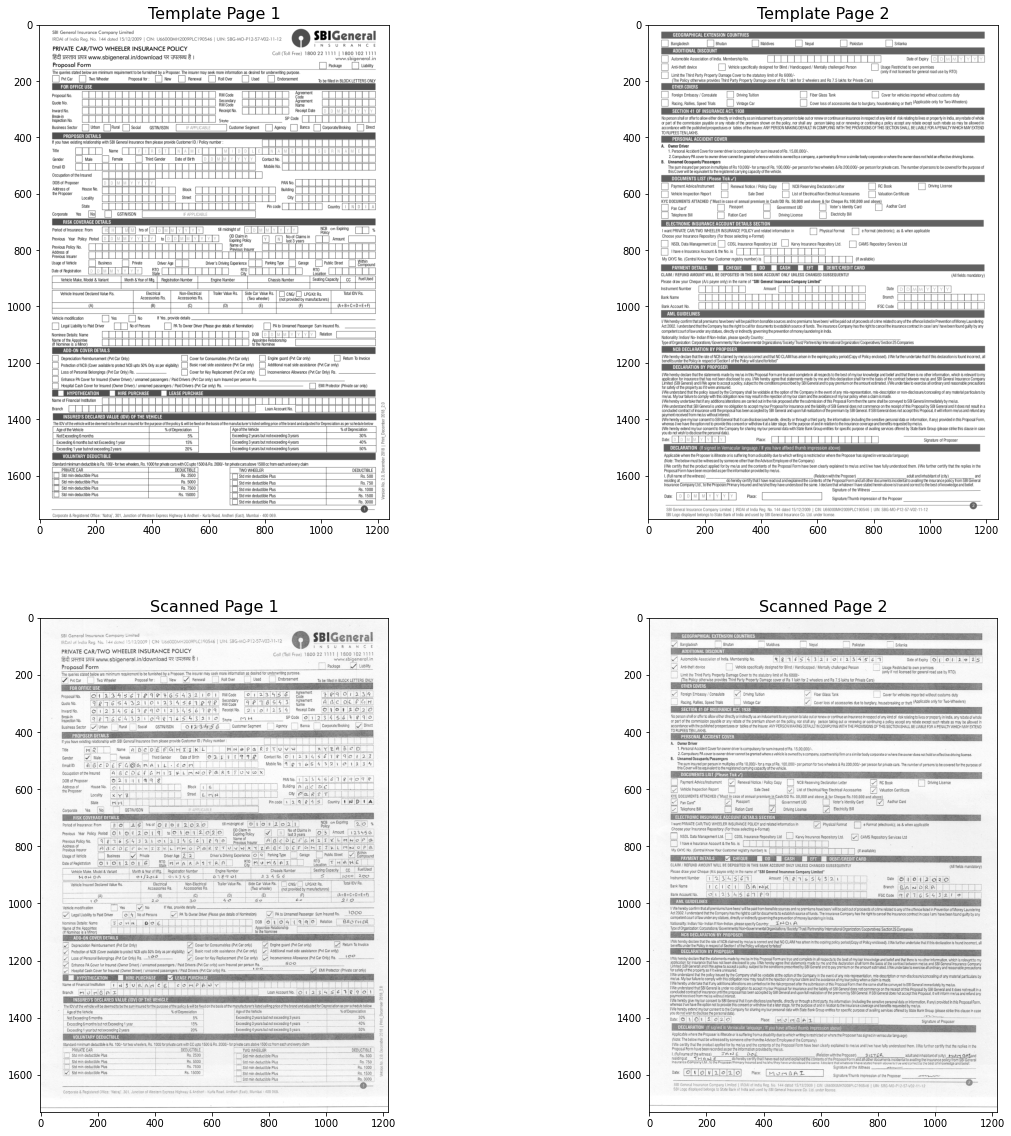

In [6]:
# Load Template Images
template_1_path = "/content/drive/MyDrive/OpenCV Tutorial/Final SBI assignment/SBI Templates/SBI_page-0001.jpg"
template_2_path = "/content/drive/MyDrive/OpenCV Tutorial/Final SBI assignment/SBI Templates/SBI_page-0002.jpg"

template_1 = cv2.imread(template_1_path)
template_1_gray = cv2.cvtColor(template_1, cv2.COLOR_BGR2GRAY)

template_2 = cv2.imread(template_2_path)
template_2_gray = cv2.cvtColor(template_2, cv2.COLOR_BGR2GRAY)

print("Size of Templates")
print("Page 1 - ", template_1_gray.shape)
print("Page 2 - ", template_2_gray.shape)


# Load Scaned Images
scan_1_path = "/content/drive/MyDrive/OpenCV Tutorial/Final SBI assignment/SBI Scans/SBI_Scan-1_page.jpg"
scan_2_path = "/content/drive/MyDrive/OpenCV Tutorial/Final SBI assignment/SBI Scans/SBI_Scan-2_page.jpg"

scan_1 = cv2.imread(scan_1_path)
scan_1_gray = cv2.cvtColor(scan_1, cv2.COLOR_BGR2GRAY)

scan_2 = cv2.imread(scan_2_path)
scan_2_gray = cv2.cvtColor(scan_2, cv2.COLOR_BGR2GRAY)

print("\nSize of Scanned Images")
print("Page 1 - ", scan_1_gray.shape)
print("Page 2 - ", scan_2_gray.shape)


# Plotting Images
fig, ax = plt.subplots(2, 2, figsize = (20, 20))

ax[0, 0].imshow(template_1_gray, cmap = "gray")
ax[0, 0].set_title("Template Page 1", size = 16)
ax[0, 1].imshow(template_2_gray, cmap = "gray")
ax[0, 1].set_title("Template Page 2", size = 16)

ax[1, 0].imshow(scan_1_gray, cmap = "gray")
ax[1, 0].set_title("Scanned Page 1", size = 16)
ax[1, 1].imshow(scan_2_gray, cmap = "gray")
ax[1, 1].set_title("Scanned Page 2", size = 16)

plt.show()

As seen, the sizes clearly do not match, so we will use the **align_imgs()** function from above to align the images with the templates

# Aligning Scanned Images With Template

**Page 1**

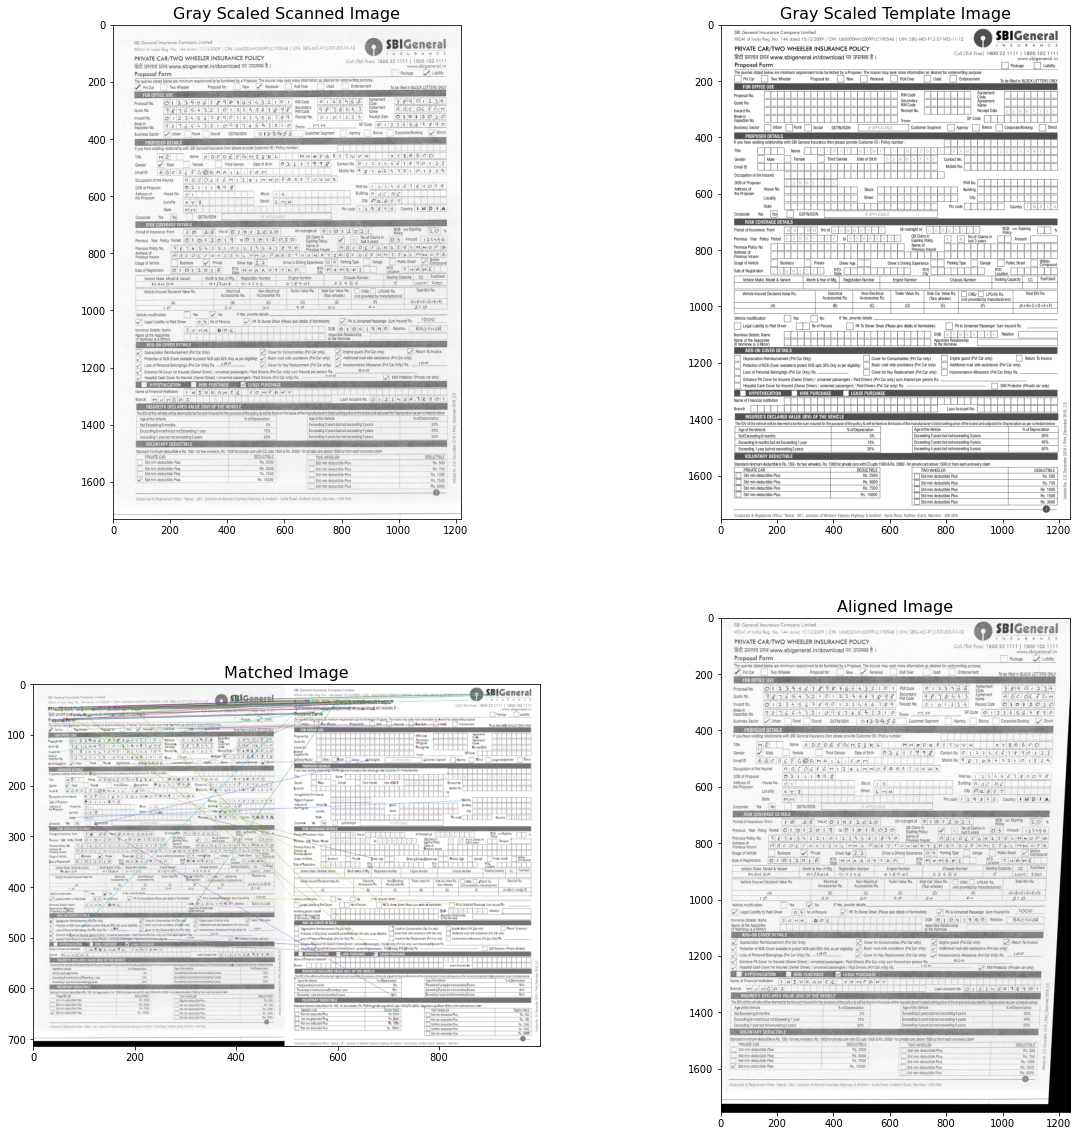

In [7]:
(scan_1_gray, template_1_gray, matched_1, aligned_1) = align_imgs(scan_1_gray, 
                                                                  template_1_gray, 
                                                                  maxFeatures = 1500, 
                                                                  keepPercent = 0.2)

fig, ax = plt.subplots(2, 2, figsize = (20, 20))

ax[0, 0].imshow(scan_1_gray, cmap = "gray")
ax[0, 0].set_title("Gray Scaled Scanned Image", size = 16)

ax[0, 1].imshow(template_1_gray, cmap = "gray")
ax[0, 1].set_title("Gray Scaled Template Image", size = 16)

ax[1, 0].imshow(matched_1, cmap = "gray")
ax[1, 0].set_title("Matched Image", size = 16)

ax[1, 1].imshow(aligned_1, cmap = "gray")
ax[1, 1].set_title("Aligned Image", size = 16)

plt.show()

**Page 2**

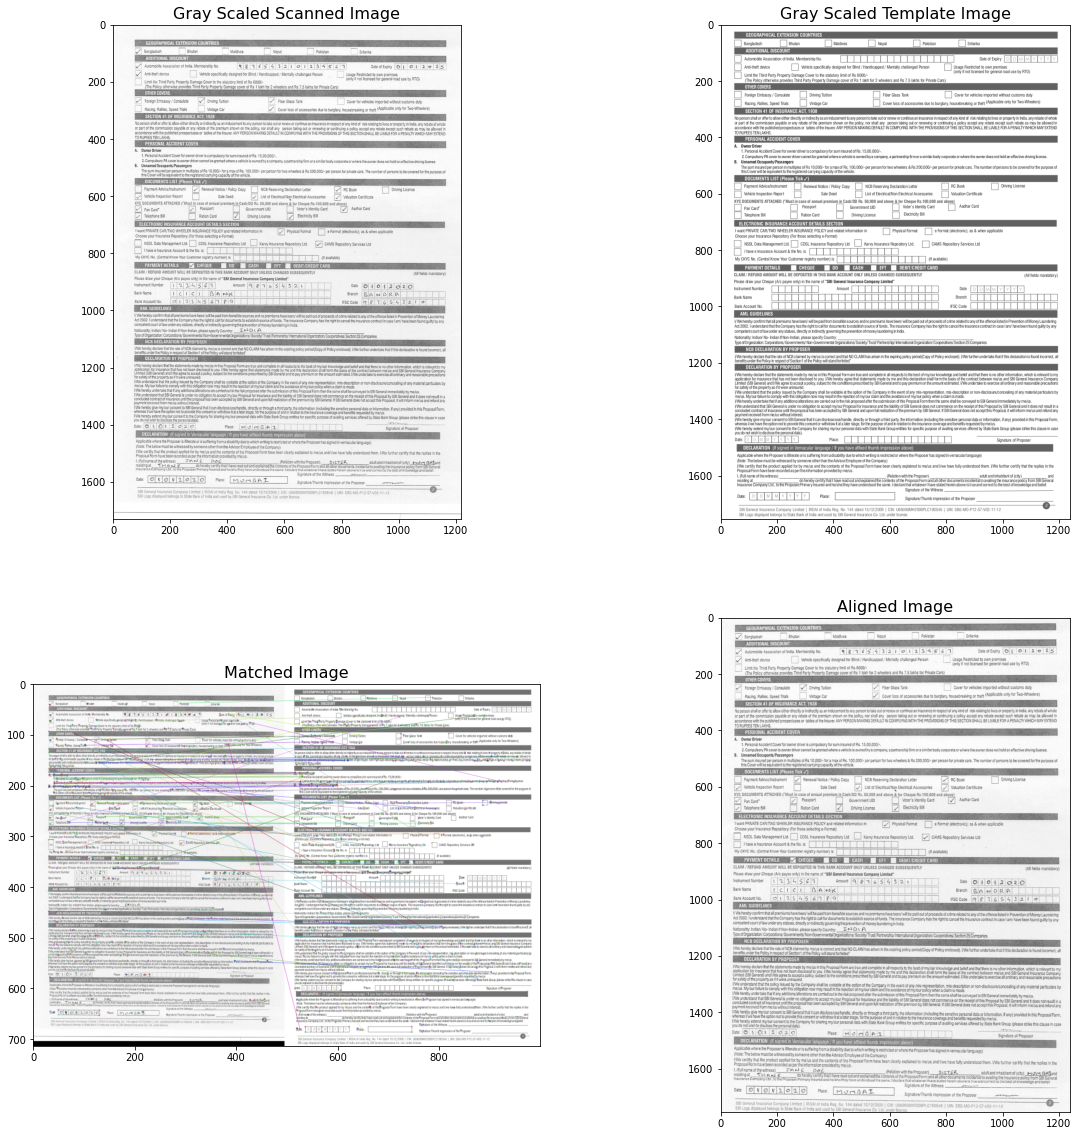

In [8]:
(scan_2_gray, template_2_gray, matched_2, aligned_2) = align_imgs(scan_2_gray, 
                                                                  template_2_gray, 
                                                                  maxFeatures = 1500, 
                                                                  keepPercent = 0.2)

fig, ax = plt.subplots(2, 2, figsize = (20, 20))

ax[0, 0].imshow(scan_2_gray, cmap = "gray")
ax[0, 0].set_title("Gray Scaled Scanned Image", size = 16)

ax[0, 1].imshow(template_2_gray, cmap = "gray")
ax[0, 1].set_title("Gray Scaled Template Image", size = 16)

ax[1, 0].imshow(matched_2, cmap = "gray")
ax[1, 0].set_title("Matched Image", size = 16)

ax[1, 1].imshow(aligned_2, cmap = "gray")
ax[1, 1].set_title("Aligned Image", size = 16)

plt.show()

Now the images have the same size as the template.

In [9]:
print("Aligned Scaned Images")
print("Page 1: ", aligned_1.shape)
print("Page 2: ", aligned_2.shape)

print("\nTemplate Images")
print("Page 1: ", template_1.shape)
print("Page 2: ", template_2.shape)

Aligned Scaned Images
Page 1:  (1754, 1241)
Page 2:  (1754, 1241)

Template Images
Page 1:  (1754, 1241, 3)
Page 2:  (1754, 1241, 3)


# OCR

## "PROPOSER DETAILS" Section

**Ticks**

- We first create a **namedtuple** that will store the id, bounding box and the trim percent for each region of interest. 
- The bounding boxes for each roi can be found by analysing the template image in a photo editor (like paint, photoshop, etc.)
- Then we loop over all the namedtuples that define our regon of interest and pass the bounding box and the trim percent parameters in the **pred_tick_roi()** function.
- The result of the previous step becomes the **value**, and the id attribute of the roi in the namedtuple becomes the **key** in the results dictionary.
- Finally, the results of all the roi's are printed.

In [10]:
OCRTicks = namedtuple("OCRTicks", ["id", "bbox", "trim"])

OCR_TICKS = [
  OCRTicks("Gender:Male",     (125, 468, 149, 493), 0.2),
  OCRTicks("Gender:Female",   (219, 468, 243, 493), 0.2),
  OCRTicks("Gender:Other",    (335, 468, 360, 493), 0.2),
]

tick_results_dict = dict()
for ocr_tick in OCR_TICKS:
  id, bbox, trim = ocr_tick
  txt = pred_tick_roi(aligned_1, bbox, trim = trim)
  tick_results_dict[id] = txt

print("RESULTS")
for key, value in tick_results_dict.items():
  print(str(key) + ": " + str(value)) 

RESULTS
Gender:Male: Yes
Gender:Female: No
Gender:Other: No


**Text Fields**

- We first create a **namedtuple** that will store the id, bounding box, the number of inner boxes, the trim percent, and the threshold percent for each region of interest. 
- The bounding boxes for each roi can be found by analysing the template image in a photo editor (like paint, photoshop, etc.)
- Then we loop over all the namedtuples that define our regon of interest and pass the bounding box and other parameters parameters in the **pred_text_roi()** function.
- The result of the previous step becomes the **value**, and the id attribute of the roi in the namedtuple becomes the **key** in the results dictionary.
- Finally, the results of all the roi's are printed.

In [11]:
OCRLocation = namedtuple("OCRLocation", ["id", "bbox", "nob", "bt", "trim", "th"])

OCR_LOCATIONS = [
  OCRLocation("Title",        (128, 445, 220, 460),   4,  21, 0.2, 0.2),
  OCRLocation("Name",         (287, 440, 1191, 459),  38, 21, 0.3, 0.2),
  OCRLocation("DOB",          (570, 470, 765, 487),   8,  21, 0.3, 0.20),
  OCRLocation("Contact",      (849, 470, 1191, 487),  14, 21, 0.3, 0.2),
  OCRLocation("Email",        (123, 498, 765, 520),   27, 21, 0.4, 0.4),
  OCRLocation("Mobile",       (846, 500, 1191, 515),  14, 21, 0.3, 0.2),
  OCRLocation("Occupation",   (219, 525, 789, 544),   24, 20, 0.3, 0.2),
  OCRLocation("DOB_proposer", (219, 557, 411, 572),   8,  21, 0.3, 0.2),
  OCRLocation("PAN",          (893, 557, 1191, 571),  12, 21, 0.3, 0.2),
  OCRLocation("House",        (218, 583, 483, 598),   11, 21, 0.3, 0.4),
  OCRLocation("Block",        (544, 583, 836, 598),   12, 21, 0.3, 0.6),
  OCRLocation("Building",     (890, 582, 1191, 600),  12, 21, 0.3, 0.3),
  OCRLocation("Locality",     (216, 608, 475, 627),   11, 21, 0.3, 0.3),
  OCRLocation("Street",       (540, 608, 823, 627),   12, 21, 0.3, 0.3),
  OCRLocation("City",         (891, 608, 1191, 627),  12, 21, 0.3, 0.3),
  OCRLocation("State",        (215, 636, 754, 656),   23, 20, 0.3, 0.5),
  OCRLocation("Pincode",      (842, 636, 983, 656),   6,  21, 0.2, 0.2),
  OCRLocation("Country",      (1050, 636, 1191, 656), 5,  20, 0.2, 0.2),
]

results_dict = dict()
for ocr_loc in OCR_LOCATIONS:
  id, bbox, nob, bt, trim, th = ocr_loc
  txt = pred_txt_roi(aligned_1, bbox, nob, bt, model, trim = trim, th = th)
  results_dict[id] = txt

print("RESULTS")
for key, value in results_dict.items():
  print(str(key) + ": " + str(value)) 

RESULTS
Title: MR
Name: ABGBEZGHZIKMHZHIFFJTT4BBBZZ
DOB: 02L1199R
Contact: 0123U561FMJ
Email: ABKDEFQGMA711111111
Mobile: 98765432N13
Occupation: ABE3EFGHTGGLMM9B8B5IDG
DOB_proposer: 02111978
PAN: 123456784JH1
House: 01
Block: 15
Building: ABCDE
Locality: XYZ
Street: LMNW
City: PQR5T1
State: MH
Pincode: 129845
Country: 1ND1A
